In [70]:
import pandas as pd
import numpy as np
import csv

In [59]:
#M, avgMSR, maxMSR, OHS, OHK, OHS+OHK, topHs, topHk
optimal=np.loadtxt("avgMSR_maxMSR_optH_topH.d")

In [60]:
rats=[20382,24101,21012,22295,20630,22098,23783,24116]
path="../data_gen/"
df = pd.DataFrame()

In [61]:
for i in range(len(rats)):
    ratid=rats[i]
    data=pd.read_json(path+"Rat_"+str(ratid)+"_resrel_data.json",orient="records")
    #print(data.columns)
    data['LOC']=data['LOC'].apply(lambda x: x[-1])
    data['PInfo']=data['PInfo'].apply(lambda x: x['content'])
    data['HInfo']=data['HInfo'].apply(lambda x: x['content'])

    data['poss_PInfo']=data['poss_PInfo'].apply(lambda x: x['content'])
    data['poss_HInfo']=data['poss_HInfo'].apply(lambda x: x['content'])

    # Grouping and calculating mean or sum for specified columns based on group size
    grouped_df = data.groupby('NeuID')
    columns_to_mean = ['Nspikes', 'MSR', 'MHK','MHS','dt_MHK', 'OHK', 'OHS', 'dt_OHK', 'max_HSHK', 'PInfo', 'HInfo','poss_MSR', 'poss_MHK','poss_MHS','poss_dt_MHK', 'poss_OHK', 'poss_OHS','poss_dt_OHK', 'poss_max_HSHK', 'poss_PInfo', 'poss_HInfo']
    tmp_df = pd.DataFrame()
    for name, group in grouped_df:
        if len(group) > 1:
            result_values = group[columns_to_mean].mean()
        else:
            result_values = group[columns_to_mean].sum()
        tmp_df = pd.concat([tmp_df, result_values.to_frame(name=name).T])
    tmp_df['RatID'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['RAT_ID'])
    tmp_df['LOC'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['LOC'])
    tmp_df['task'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['task'])
    columns = tmp_df.columns.tolist()
    tmp_df=tmp_df[ columns[-3:] + columns[:-3]]
    tmp_df.reset_index(inplace=True)
    tmp_df.rename(columns={'index': 'NeuID'}, inplace=True)
    #print(df.columns)
    df = pd.concat([df,tmp_df], ignore_index=True)


In [62]:
df.columns

Index(['NeuID', 'RatID', 'LOC', 'task', 'Nspikes', 'MSR', 'MHK', 'MHS',
       'dt_MHK', 'OHK', 'OHS', 'dt_OHK', 'max_HSHK', 'PInfo', 'HInfo',
       'poss_MSR', 'poss_MHK', 'poss_MHS', 'poss_dt_MHK', 'poss_OHK',
       'poss_OHS', 'poss_dt_OHK', 'poss_max_HSHK', 'poss_PInfo', 'poss_HInfo'],
      dtype='object')

In [63]:
from scipy import interpolate
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update(mpl.rcParamsDefault)

In [64]:
mss=120
fontssize=50
mpl.rcParams.update({
    'figure.figsize': (23.6,12.6),
    'font.family': 'serif',
    'font.serif': ['Liberation Sans'],  # Add or remove font names as needed
    'font.size': fontssize,  # Adjust as needed
    #'font.weight': 'bold',
    "svg.fonttype": 'none',
    'text.usetex': False,
    'axes.linewidth' : 2,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{cmbright}',
    'xtick.labelsize' : fontssize, # fontsize of the x tick labels
    'ytick.labelsize' : fontssize # fontsize of the y tick labels
})
ticks_font = font_manager.FontProperties(family='Liberation Sans', style='normal',
    size=fontssize, weight='bold', stretch='normal')
tf = {}


Fraction of CA1 neurons withitn 10 - 10^3 Nspikes band

In [65]:
df.query('LOC=="CA1" and 1e1<Nspikes<1e3').shape[0]/df.query('LOC=="CA1"').shape[0],df.query('LOC=="CA1" and 1e3<Nspikes<1e4').shape[0]/df.query('LOC=="CA1"').shape[0]

(0.6875, 0.3014705882352941)

Fraction of SUB neurons withitn 10^3 - 10^4 Nspikes band

In [66]:
df.query('LOC=="SUB" and 1e1<Nspikes<1e3').shape[0]/df.query('LOC=="SUB"').shape[0],df.query('LOC=="SUB" and 1e3<Nspikes<1e4').shape[0]/df.query('LOC=="SUB"').shape[0]

(0.08679245283018867, 0.8301886792452831)

Nspike band containing 80% of SUB neurons

In [67]:
df.query('LOC=="SUB" and Nspikes>2050').shape[0]/df.query('LOC=="SUB"').shape[0]

0.8

Nspike band containing 80% of CA1 neurons

In [68]:
df.query('LOC=="CA1" and Nspikes<1550').shape[0]/df.query('LOC=="CA1"').shape[0]

0.8051470588235294

In the Optimal values file `avgMSR_maxMSR_optH_topH.d` these rows represent the measures

Number of spikes-0, poss_MSR_opt-1,MSR-2,MHK-6,OHK-4,OHS-3,OHK+OHS-5

Plot for MSR

slope_CA1: 8.39E-04 std_CA1:0.0069
slope_SUB: -5.32E-03 std_SUB:0.0112
slope_Poss: -6.57E-03 std_rand_CA1:0.0096


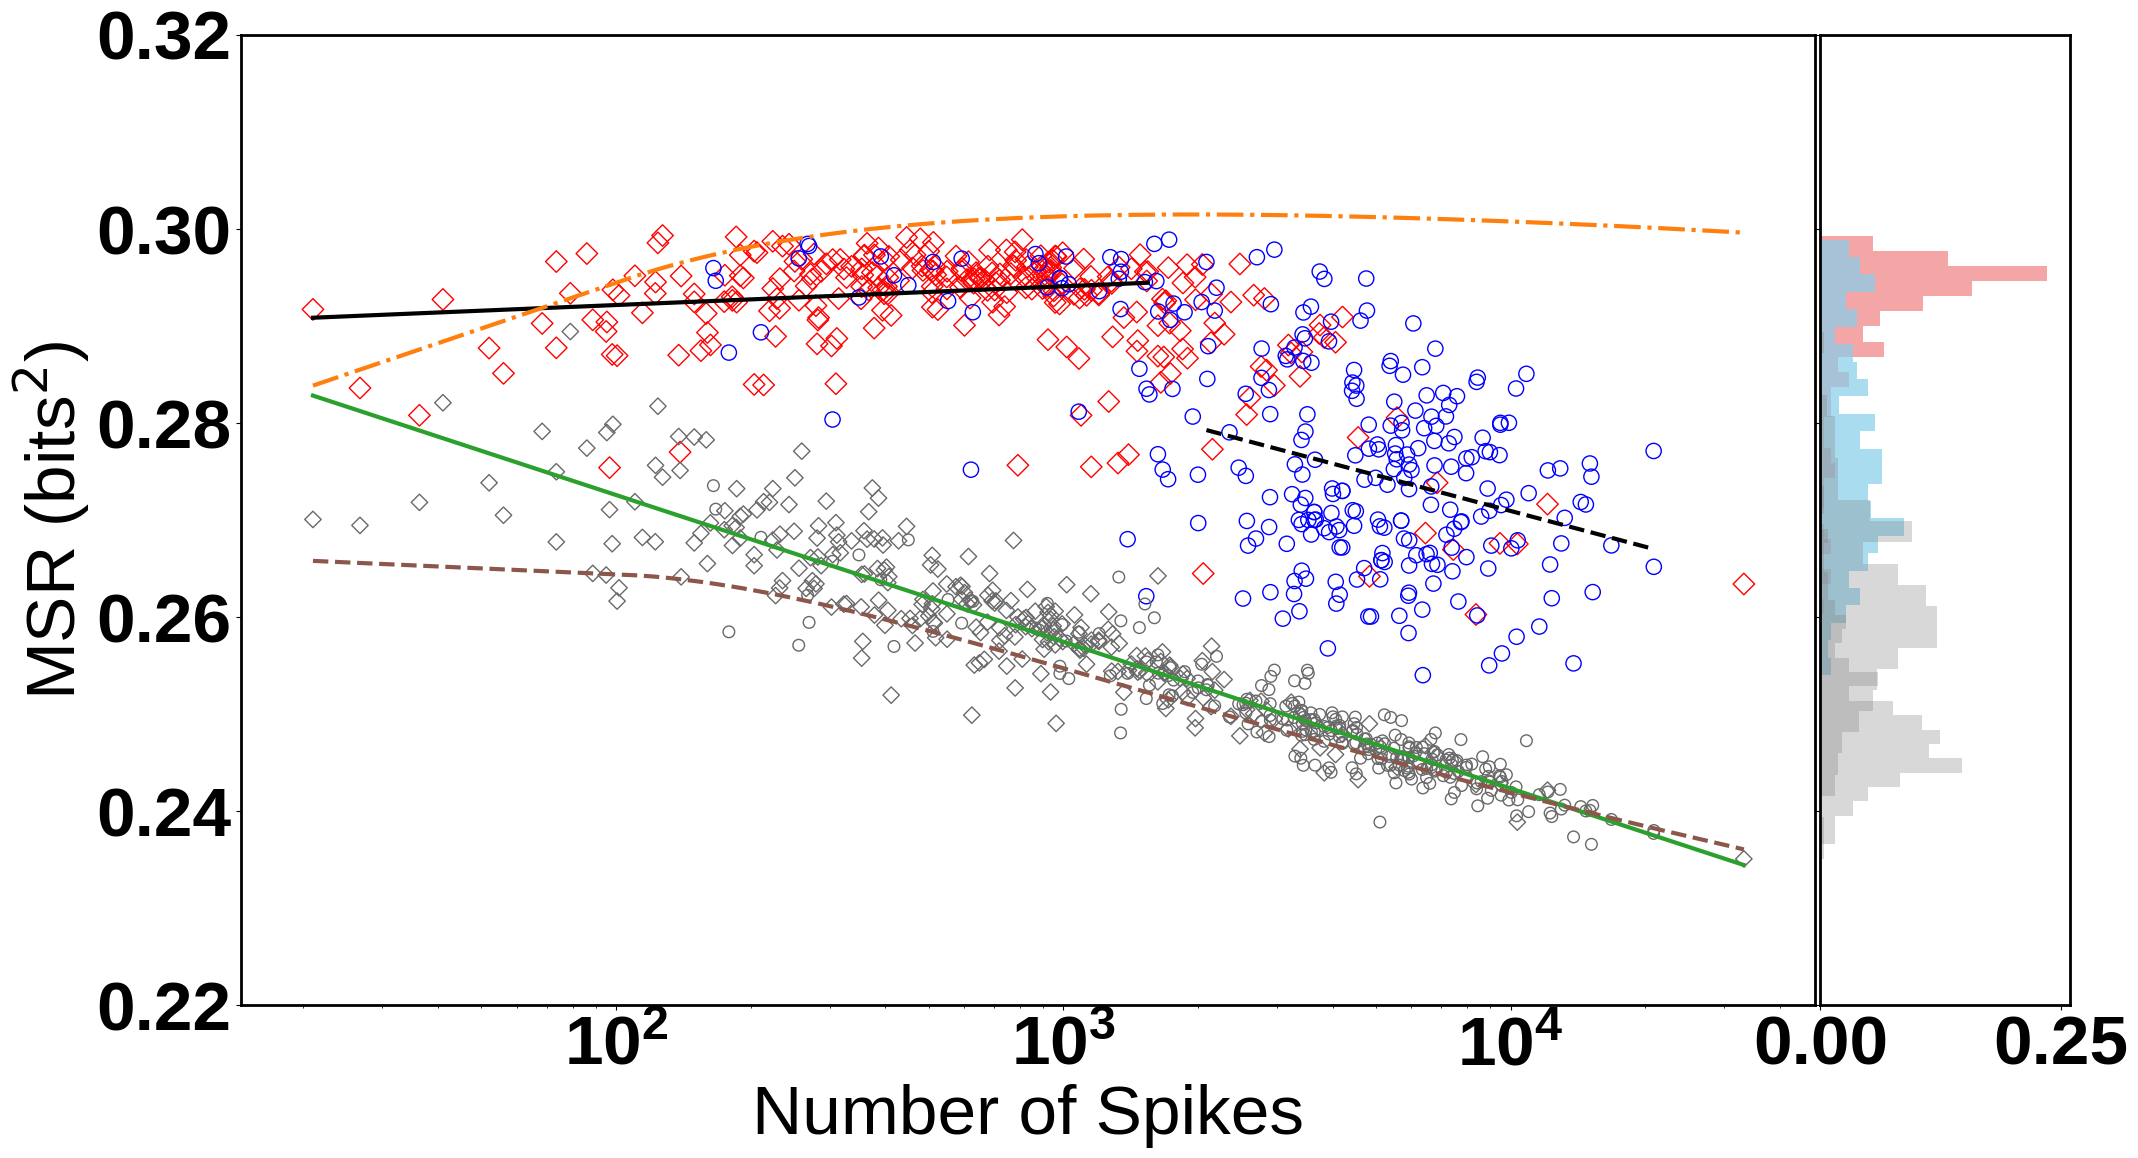

In [69]:
# Create scatter plot
fig, ax = plt.subplots()
quant='MSR'
quant_lab=r'MSR (bits$^2$)'
figname='../figures/MSRvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1A.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,2],fill_value="extrapolate")
msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)

#Best Fit semi-log line with 80% CA1s with Nspike<1550
dfC=df.query('LOC=="CA1" and Nspikes<1550').sort_values(by='Nspikes')
resC = stats.linregress(np.log(dfC['Nspikes']), dfC[quant])
ax.plot(dfC['Nspikes'], resC.intercept + resC.slope*np.log(dfC['Nspikes'].values), '-',color='black',linewidth=3,label='CA1 80p semi-log regression fit')

#Best Fit semi-log line with 80% SUBs with Nspikes>2050
dfS=df.query('LOC=="SUB" and Nspikes>2050').sort_values(by='Nspikes')
resS = stats.linregress(np.log(dfS['Nspikes']), dfS[quant])
ax.plot(dfS['Nspikes'], resS.intercept + resS.slope*np.log(dfS['Nspikes'].values), '--',color='black', linewidth=3,label='SUB 80p semi-log regression fit')

# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)

#Best Fit semi-log line for all poss data-points
df_poss=df.sort_values(by='Nspikes')
resPoss = stats.linregress(np.log(df_poss['Nspikes']), df_poss['poss_'+quant])
ax.plot(df_poss['Nspikes'], resPoss.intercept + resPoss.slope*np.log(df_poss['Nspikes'].values),'-',color='tab:green', linewidth=3,label='all poss semi-log regression fit')


# #Line plot for optimal MSR
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_ylim(0.22,0.32)
ax.set_xscale('log');
ax_histy.set_xlim(0,0.26)


for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)

# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.17), ncol=3,fontsize=22)

# print the slope and std values to be reported in the figure caption
print('slope_CA1: {:.2E} std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
print('slope_SUB: {:.2E} std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
print('slope_Poss: {:.2E} std_rand_CA1:{:.4f}'.format(resPoss.slope,df['poss_'+quant].std()))

# fig.tight_layout()
fig.savefig(figname,bbox_inches='tight',dpi=300)
# plt.savefig(figname2,dpi=300)
plt.show(fig)

Generation of Plot Data File

In [81]:
filepath_plotdata='../figures_plotdata/'+figname.split('/')[-1][:-4]+'.csv'

with open(filepath_plotdata, 'w', newline='') as csvfile:
    fieldnames = ['Nspike_CA1', 'MSR_CA1','Nspike_SUB','MSR_SUB','Nspike_posCA1','MSR_posSUB','Nspike_posSUB','MSR_posCA1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(
        {
            'Nspike_CA1': x[0], 'MSR_CA1': x[1],'Nspike_SUB': y[0],'MSR_SUB': y[1],'Nspike_posCA1': z[0],'MSR_posSUB': z[1],'Nspike_posSUB': w[0],'MSR_posCA1': w[1]
        } for x,y,z,w in zip(
            df.query('LOC=="CA1"')[['Nspikes',quant]].values,
            df.query('LOC=="SUB"')[['Nspikes',quant]].values,
            df.query('LOC=="CA1"')[['Nspikes','poss_'+quant]].values,
            df.query('LOC=="SUB"')[['Nspikes','poss_'+quant]].values
            )
    )

In the Optimal values files these rows represent the measures


Number of spikes-0, poss_MSR_opt-1,MSR-2,MHK-6,OHK-4,OHS-3,OHK+OHS-5

Plot for the relevance quantities

Optimal

slope_CA1: -2.10E-05 std_CA1:0.0510
slope_SUB: -1.25E-05 std_SUB:0.0695
slope_rand_CA1: -7.67E-06 std_rand_CA1:0.0488
slope_rand_SUB: -5.03E-06 std_rand_SUB:0.0274


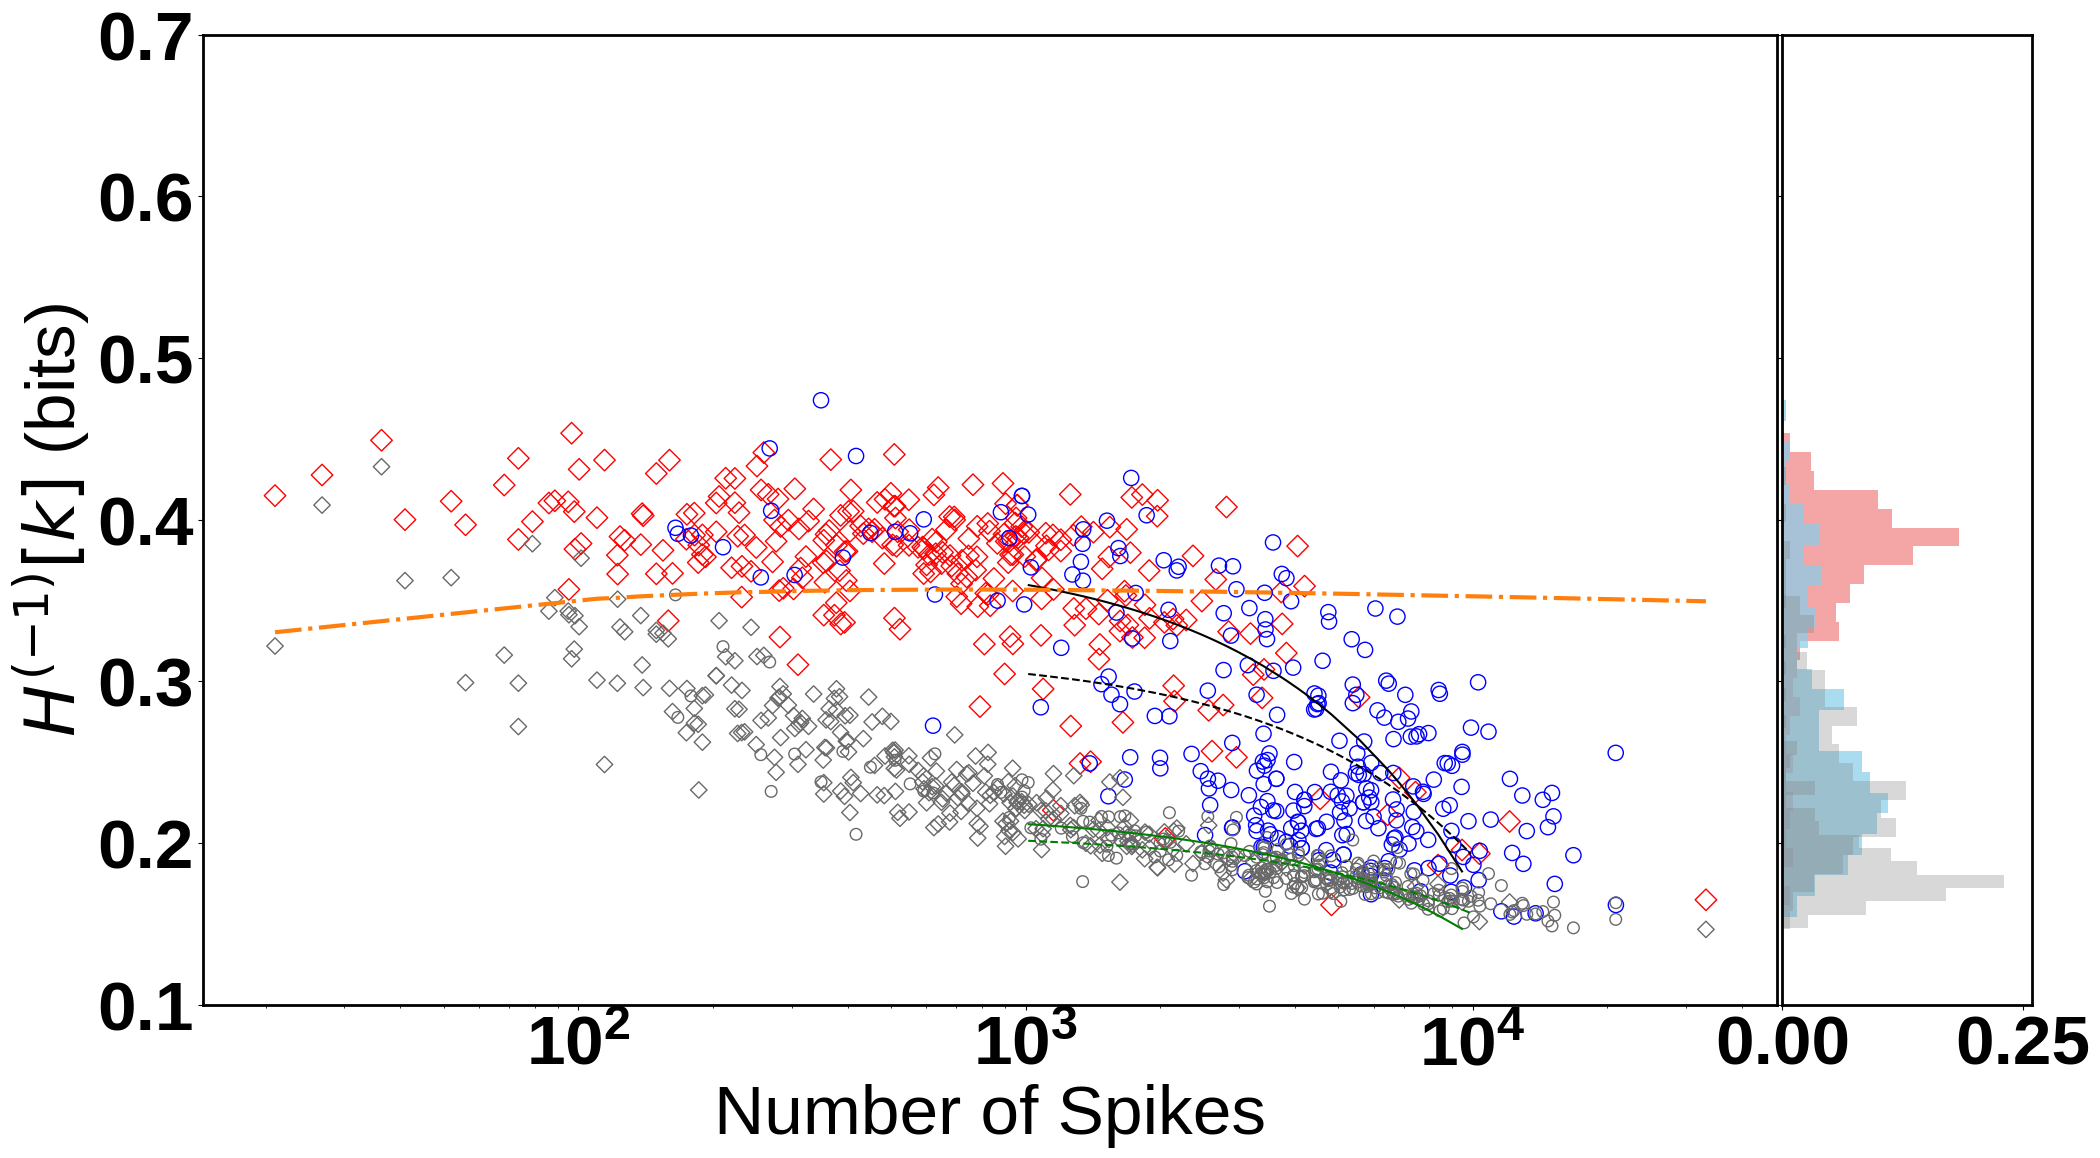

In [9]:
# Create scatter plot
fig, ax = plt.subplots()
quant='OHK'
quant_lab=r'$H^{(-1)}[k]$ (bits)'
figname='../figures/OHKvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,4],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)

# #Best Fit line Between Nspike=10^3 and Nspike=10^4
# dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
# resC = stats.linregress(dfC['Nspikes'], dfC[quant])
# ax.plot(dfC['Nspikes'], resC.intercept + resC.slope*dfC['Nspikes'].values, 'k', label='fitted line')

# dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
# resS = stats.linregress(dfS['Nspikes'], dfS[quant])
# ax.plot(dfS['Nspikes'], resS.intercept + resS.slope*dfS['Nspikes'].values, 'k--', label='fitted line')


# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)

# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# #Best Fit line Between Nspike=10^3 and Nspike=10^4
# dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
# resCp = stats.linregress(dfC['Nspikes'], dfC['poss_'+quant])
# ax.plot(dfC['Nspikes'], resCp.intercept + resCp.slope*dfC['Nspikes'].values, 'g', label='fitted line')

# dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
# resSp = stats.linregress(dfS['Nspikes'], dfS['poss_'+quant])
# ax.plot(dfS['Nspikes'], resSp.intercept + resSp.slope*dfS['Nspikes'].values, 'g--', label='fitted line')


# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.1, 0.7)
ax_histy.set_xlim(0,0.26)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# print the slope and std values to be reported in the figure caption
print('std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
print('std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
print('slope_rand_CA1: {:.2E} std_rand_CA1:{:.4f}'.format(resCp.slope,df.query('LOC=="CA1"')['poss_'+quant].std()))
print('slope_rand_SUB: {:.2E} std_rand_SUB:{:.4f}'.format(resSp.slope,df.query('LOC=="SUB"')['poss_'+quant].std()))


# # print the slope and std values to be reported in the figure caption
# print('slope_CA1: {:.2E} std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
# print('slope_SUB: {:.2E} std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
# print('slope_rand_CA1: {:.2E} std_rand_CA1:{:.4f}'.format(resCp.slope,df.query('LOC=="CA1"')['poss_'+quant].std()))
# print('slope_rand_SUB: {:.2E} std_rand_SUB:{:.4f}'.format(resSp.slope,df.query('LOC=="SUB"')['poss_'+quant].std()))



# plt.tight_layout()
fig.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

slope_CA1: 1.20E-05 std_CA1:0.0343
slope_SUB: 6.66E-06 std_SUB:0.0455
slope_rand_CA1: 3.63E-06 std_rand_CA1:0.0264
slope_rand_SUB: 2.26E-06 std_rand_SUB:0.0159


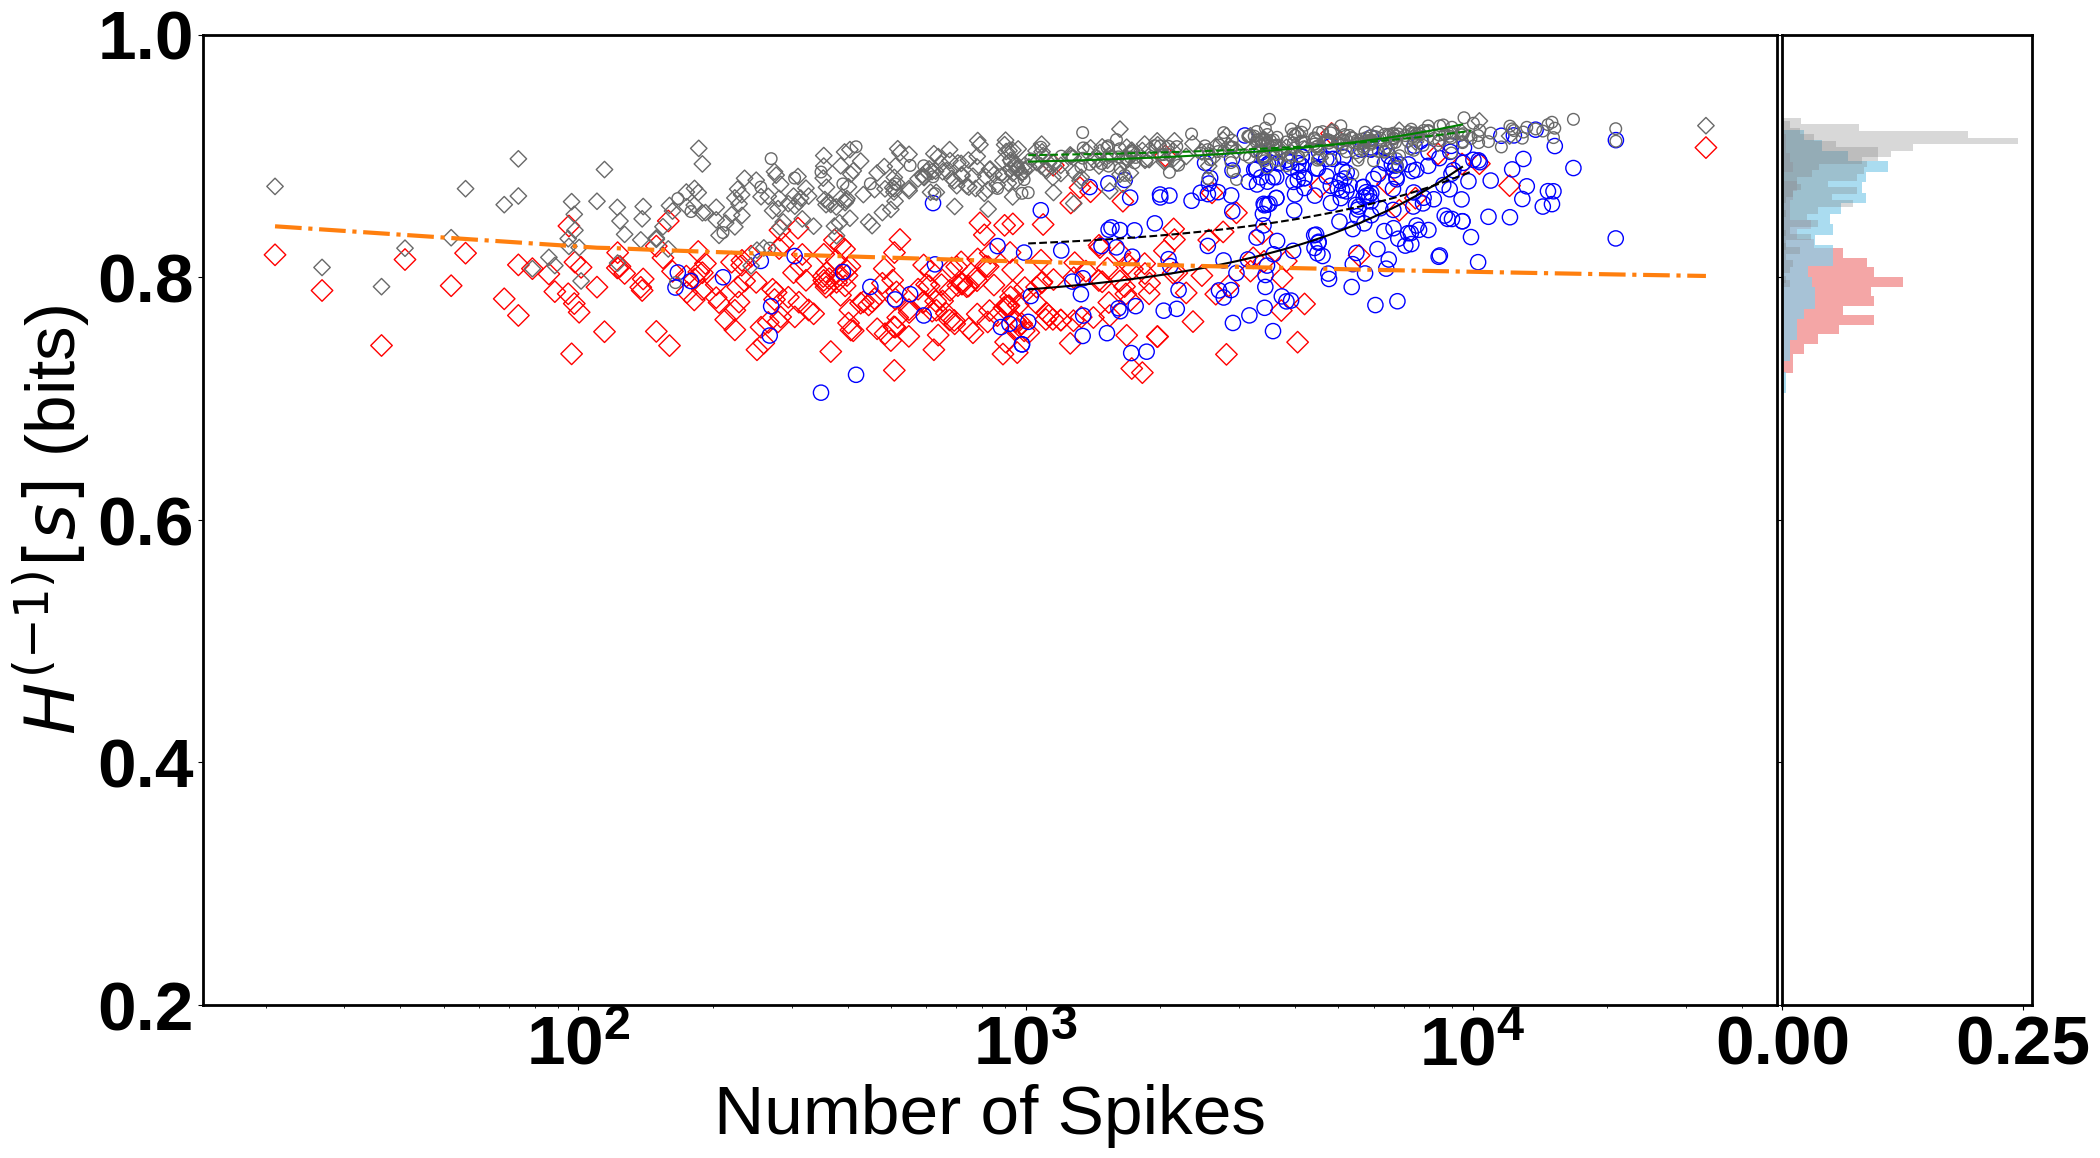

In [10]:
# Create scatter plot
fig, ax = plt.subplots()
quant='OHS'
quant_lab=r'$H^{(-1)}[s]$ (bits)'
figname='../figures/OHSvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,3],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resC = stats.linregress(dfC['Nspikes'], dfC[quant])
ax.plot(dfC['Nspikes'], resC.intercept + resC.slope*dfC['Nspikes'].values, 'k', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resS = stats.linregress(dfS['Nspikes'], dfS[quant])
ax.plot(dfS['Nspikes'], resS.intercept + resS.slope*dfS['Nspikes'].values, 'k--', label='fitted line')



# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resCp = stats.linregress(dfC['Nspikes'], dfC['poss_'+quant])
ax.plot(dfC['Nspikes'], resCp.intercept + resCp.slope*dfC['Nspikes'].values, 'g', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resSp = stats.linregress(dfS['Nspikes'], dfS['poss_'+quant])
ax.plot(dfS['Nspikes'], resSp.intercept + resSp.slope*dfS['Nspikes'].values, 'g--', label='fitted line')




# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')



# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.2, 1)
ax_histy.set_xlim(0,0.26)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)

for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
   
       
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# print the slope and std values to be reported in the figure caption
print('slope_CA1: {:.2E} std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
print('slope_SUB: {:.2E} std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
print('slope_rand_CA1: {:.2E} std_rand_CA1:{:.4f}'.format(resCp.slope,df.query('LOC=="CA1"')['poss_'+quant].std()))
print('slope_rand_SUB: {:.2E} std_rand_SUB:{:.4f}'.format(resSp.slope,df.query('LOC=="SUB"')['poss_'+quant].std()))


# plt.tight_layout()
fig.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

slope_CA1: -9.02E-06 std_CA1:0.0257
slope_SUB: -5.86E-06 std_SUB:0.0273
slope_rand_CA1: -4.04E-06 std_rand_CA1:0.0249
slope_rand_SUB: -2.77E-06 std_rand_SUB:0.0130


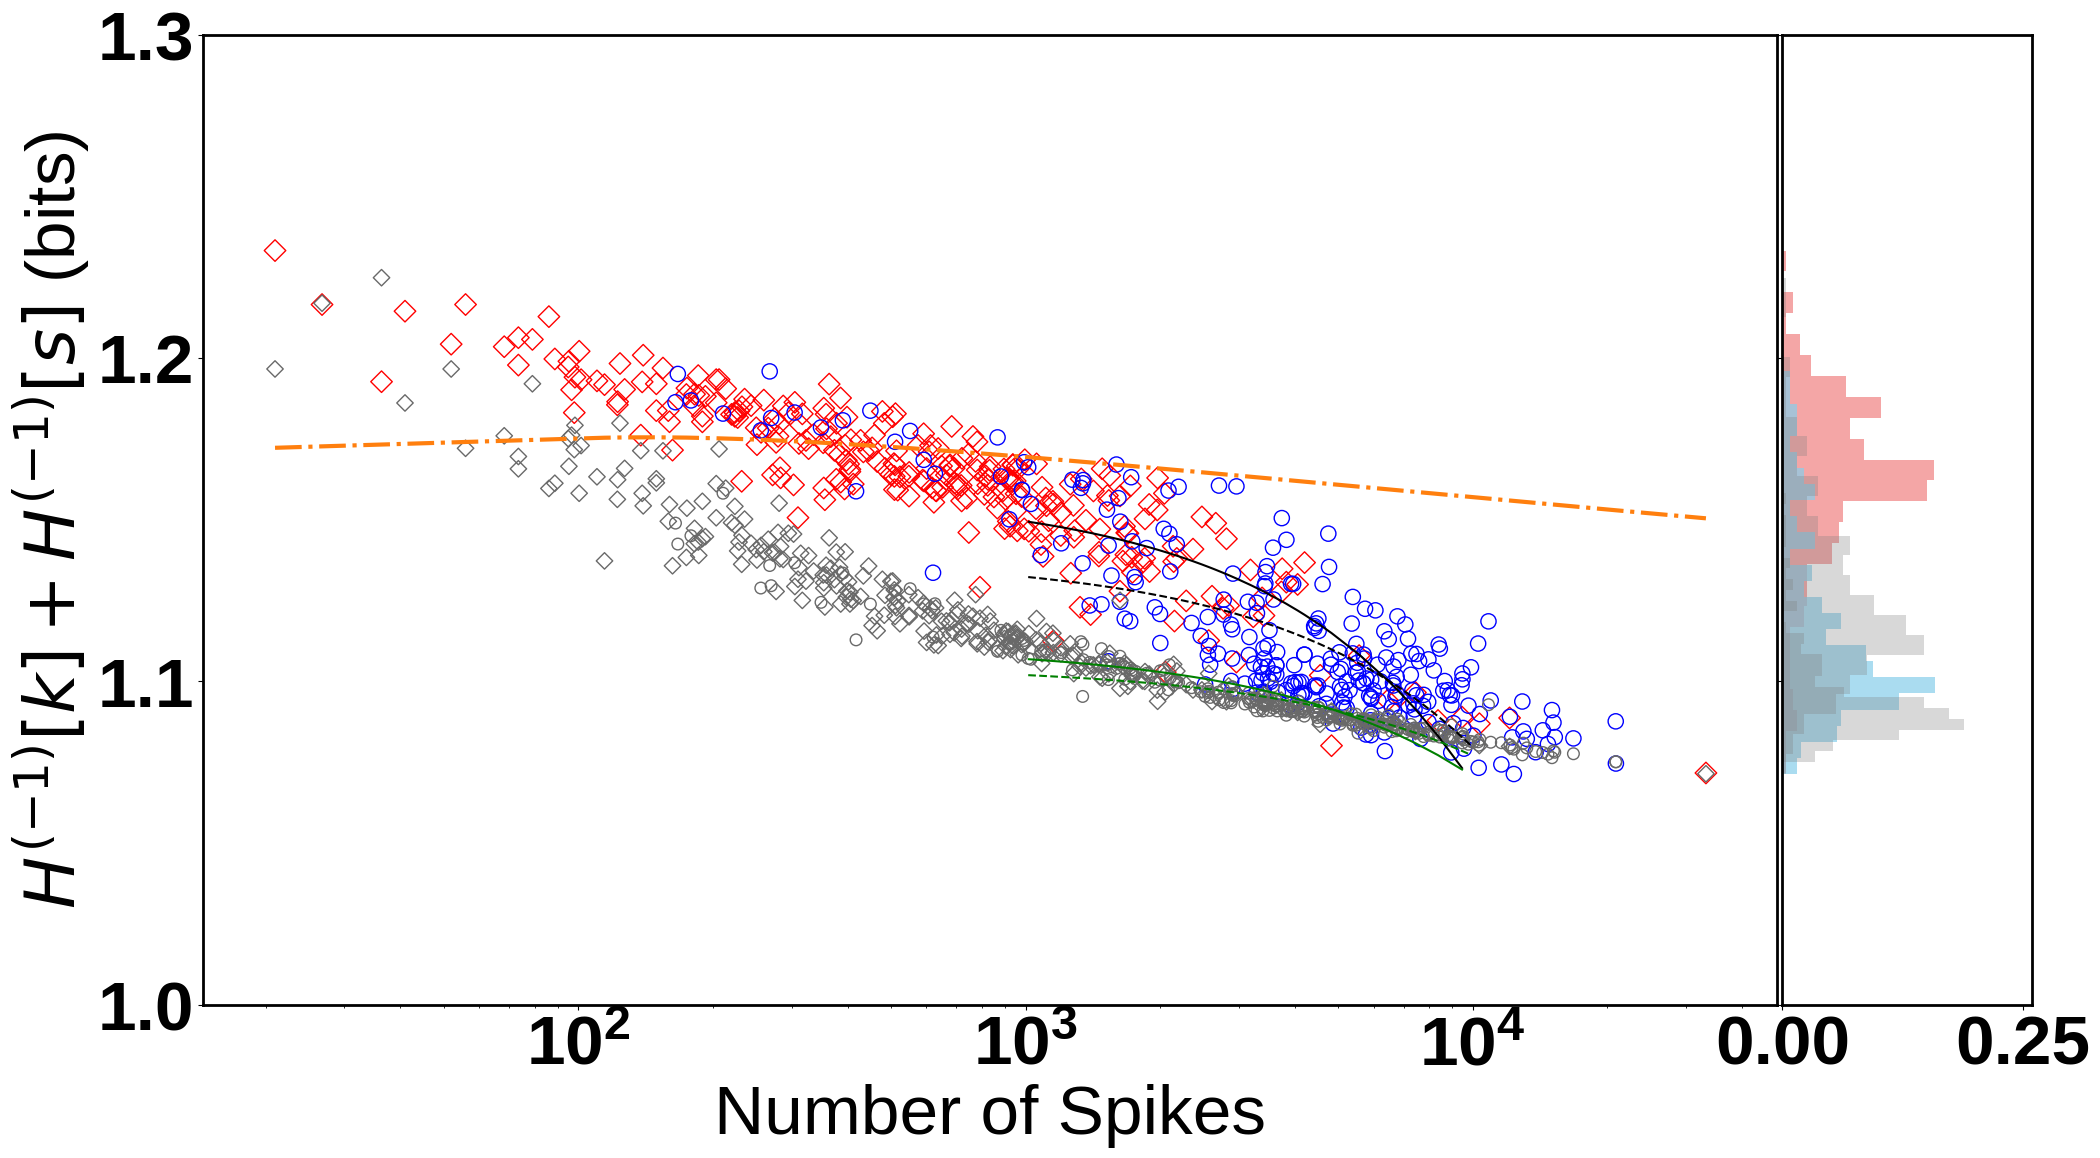

In [11]:
# Create scatter plot
fig, ax = plt.subplots()
quant='max_HSHK'
quant_lab=r'$H^{(-1)}[k] + H^{(-1)}[s]$ (bits)'
figname='../figures/OHKHSvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,5],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resC = stats.linregress(dfC['Nspikes'], dfC[quant])
ax.plot(dfC['Nspikes'], resC.intercept + resC.slope*dfC['Nspikes'].values, 'k', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resS = stats.linregress(dfS['Nspikes'], dfS[quant])
ax.plot(dfS['Nspikes'], resS.intercept + resS.slope*dfS['Nspikes'].values, 'k--', label='fitted line')


# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resCp = stats.linregress(dfC['Nspikes'], dfC['poss_'+quant])
ax.plot(dfC['Nspikes'], resCp.intercept + resCp.slope*dfC['Nspikes'].values, 'g', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resSp = stats.linregress(dfS['Nspikes'], dfS['poss_'+quant])
ax.plot(dfS['Nspikes'], resSp.intercept + resSp.slope*dfS['Nspikes'].values, 'g--', label='fitted line')


# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(1, 1.3)
ax_histy.set_xlim(0,0.26)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# print the slope and std values to be reported in the figure caption
print('slope_CA1: {:.2E} std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
print('slope_SUB: {:.2E} std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
print('slope_rand_CA1: {:.2E} std_rand_CA1:{:.4f}'.format(resCp.slope,df.query('LOC=="CA1"')['poss_'+quant].std()))
print('slope_rand_SUB: {:.2E} std_rand_SUB:{:.4f}'.format(resSp.slope,df.query('LOC=="SUB"')['poss_'+quant].std()))


# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

Maximal

slope_CA1: -5.24E-06 std_CA1:0.0148
slope_SUB: -2.10E-06 std_SUB:0.0207
slope_rand_CA1: -4.13E-06 std_rand_CA1:0.0238
slope_rand_SUB: -2.80E-06 std_rand_SUB:0.0134


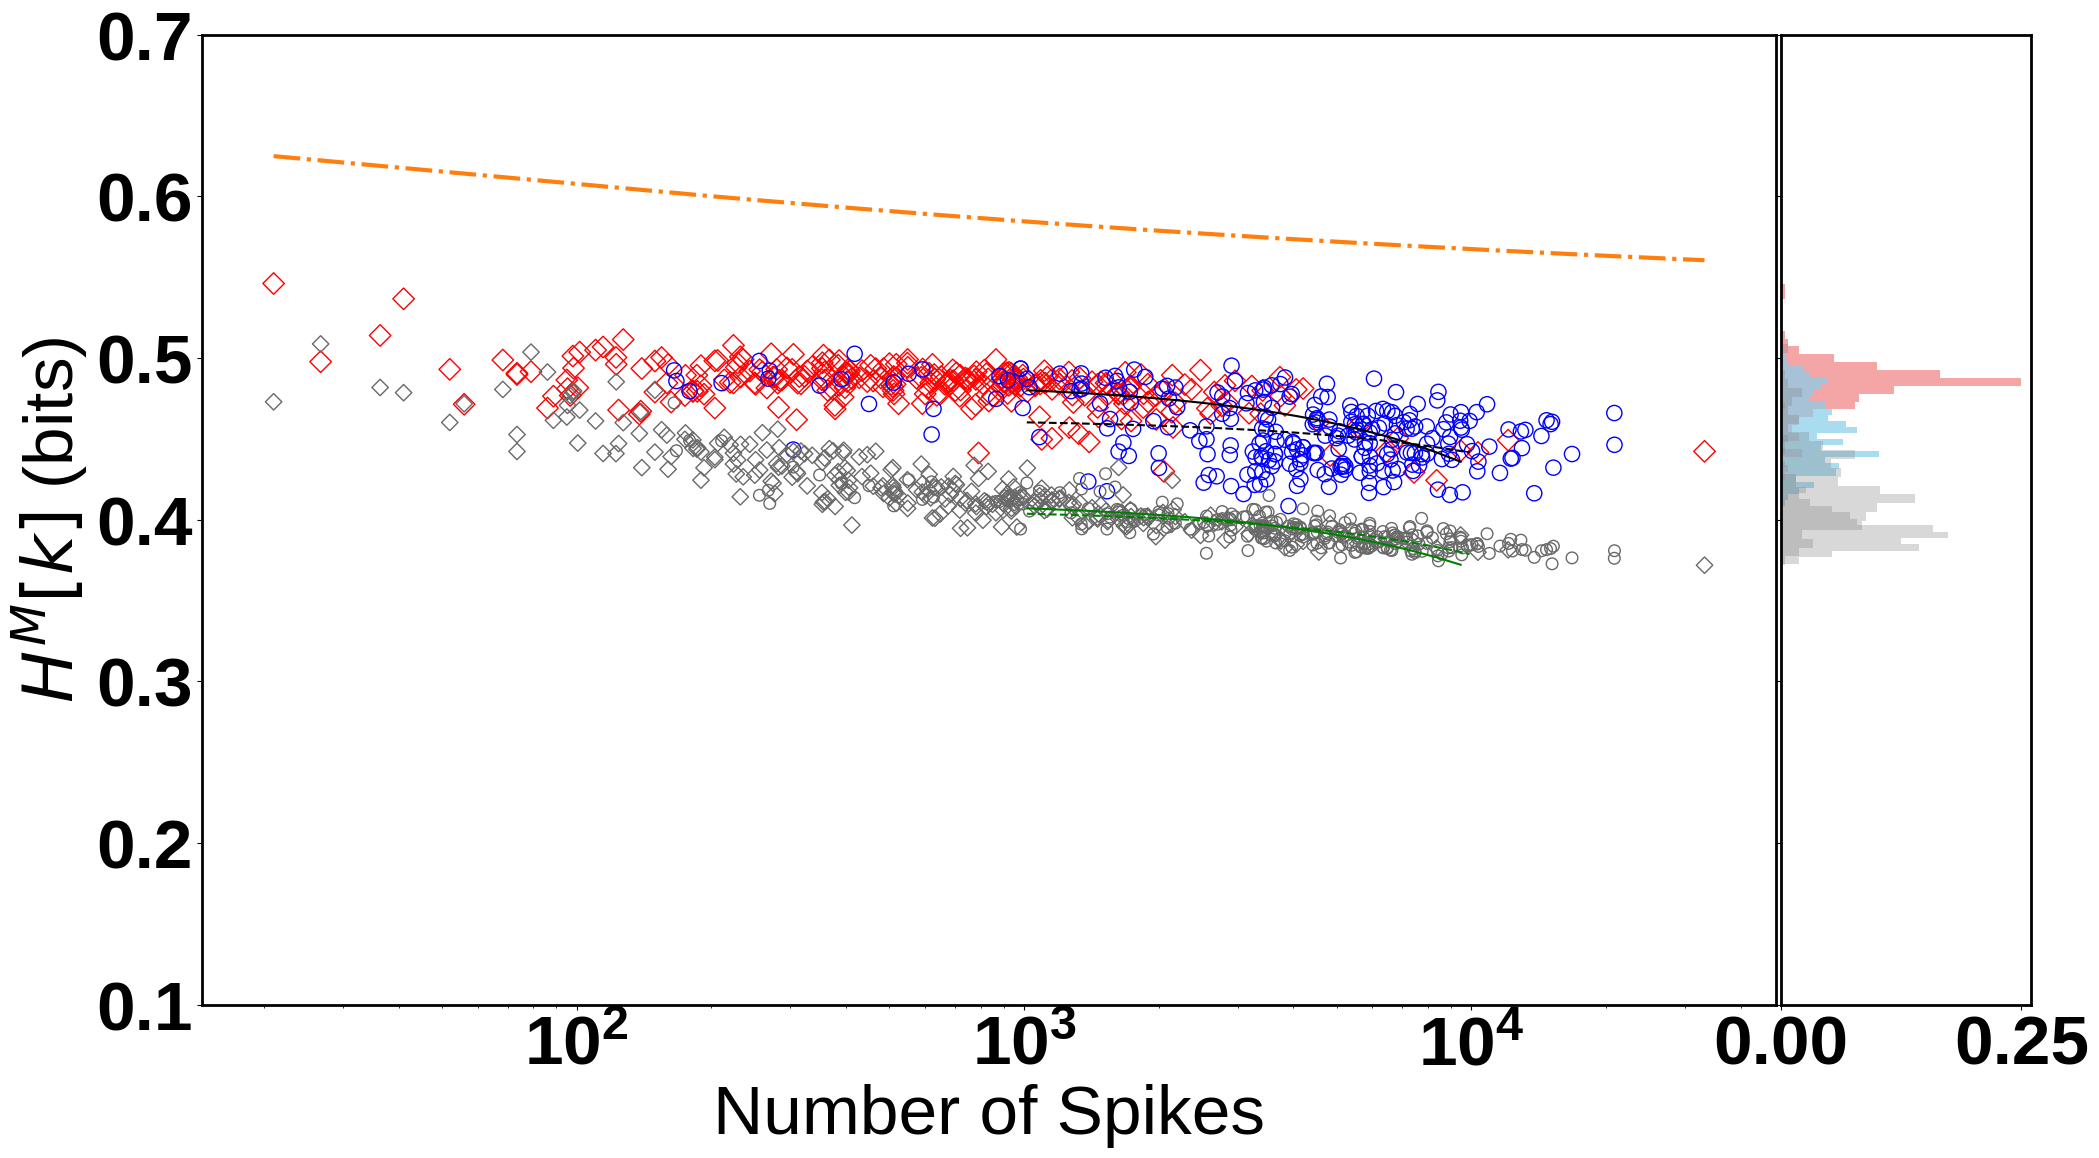

In [12]:
# Create scatter plot
fig, ax = plt.subplots()
quant='MHK'
quant_lab=r'$H^M[k]$ (bits)'
figname='../figures/MHKvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,6],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resC = stats.linregress(dfC['Nspikes'], dfC[quant])
ax.plot(dfC['Nspikes'], resC.intercept + resC.slope*dfC['Nspikes'].values, 'k', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resS = stats.linregress(dfS['Nspikes'], dfS[quant])
ax.plot(dfS['Nspikes'], resS.intercept + resS.slope*dfS['Nspikes'].values, 'k--', label='fitted line')


# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resCp = stats.linregress(dfC['Nspikes'], dfC['poss_'+quant])
ax.plot(dfC['Nspikes'], resCp.intercept + resCp.slope*dfC['Nspikes'].values, 'g', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resSp = stats.linregress(dfS['Nspikes'], dfS['poss_'+quant])
ax.plot(dfS['Nspikes'], resSp.intercept + resSp.slope*dfS['Nspikes'].values, 'g--', label='fitted line')


# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.1, 0.7)
ax_histy.set_xlim(0,0.26)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# print the slope and std values to be reported in the figure caption
print('slope_CA1: {:.2E} std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
print('slope_SUB: {:.2E} std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
print('slope_rand_CA1: {:.2E} std_rand_CA1:{:.4f}'.format(resCp.slope,df.query('LOC=="CA1"')['poss_'+quant].std()))
print('slope_rand_SUB: {:.2E} std_rand_SUB:{:.4f}'.format(resSp.slope,df.query('LOC=="SUB"')['poss_'+quant].std()))


# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

slope_CA1: -6.78E-06 std_CA1:0.0321
slope_SUB: -3.91E-06 std_SUB:0.0330
slope_rand_CA1: -4.57E-06 std_rand_CA1:0.0404
slope_rand_SUB: -3.85E-06 std_rand_SUB:0.0272


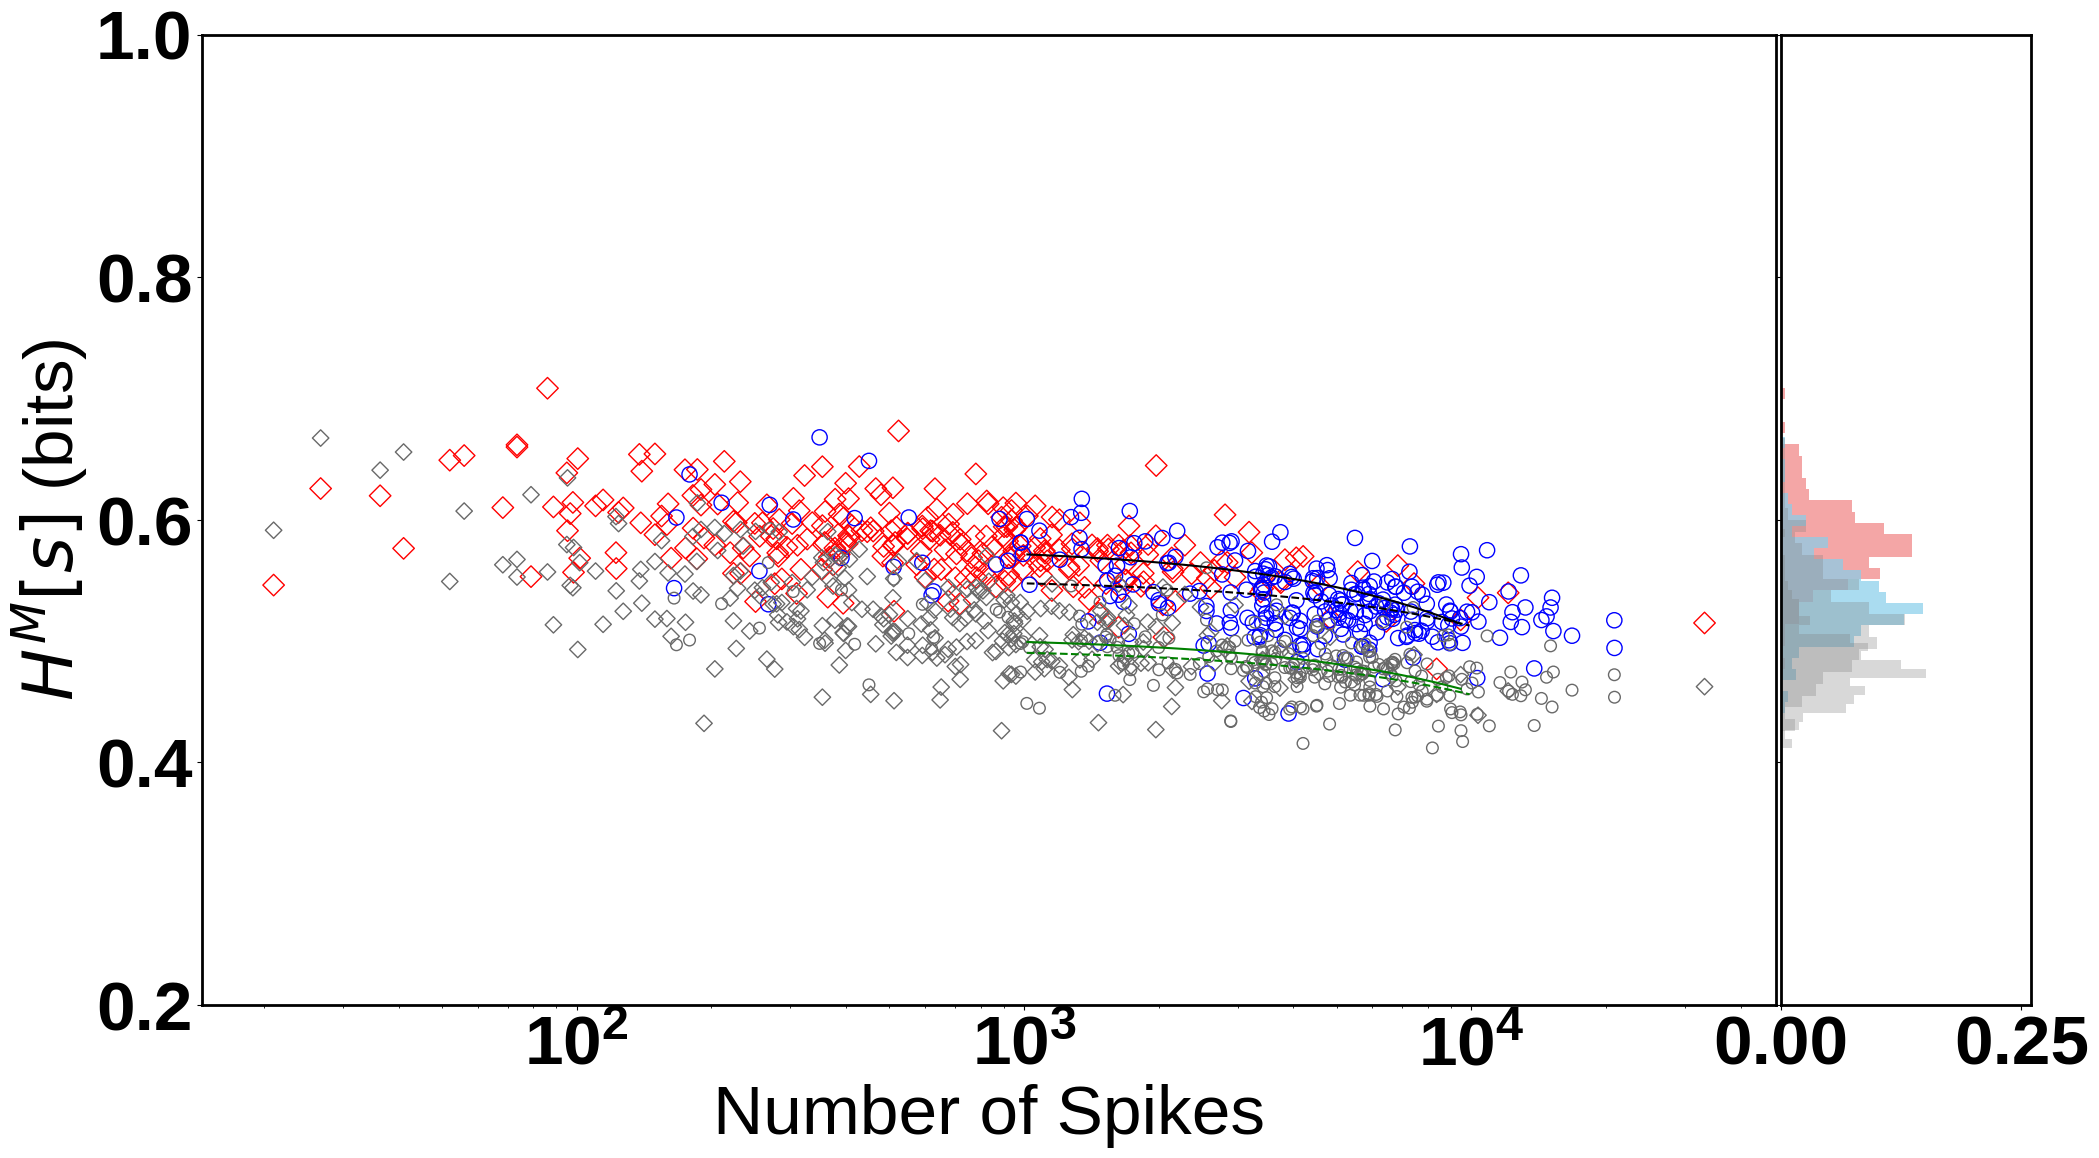

In [13]:
# Create scatter plot
fig, ax = plt.subplots()
quant='MHS'
quant_lab=r'$H^M[s]$ (bits)'
figname='../figures/MHSvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

#msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,6],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resC = stats.linregress(dfC['Nspikes'], dfC[quant])
ax.plot(dfC['Nspikes'], resC.intercept + resC.slope*dfC['Nspikes'].values, 'k', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resS = stats.linregress(dfS['Nspikes'], dfS[quant])
ax.plot(dfS['Nspikes'], resS.intercept + resS.slope*dfS['Nspikes'].values, 'k--', label='fitted line')


# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)

#Best Fit line Between Nspike=10^3 and Nspike=10^4
dfC=df.query('LOC=="CA1" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resCp = stats.linregress(dfC['Nspikes'], dfC['poss_'+quant])
ax.plot(dfC['Nspikes'], resCp.intercept + resCp.slope*dfC['Nspikes'].values, 'g', label='fitted line')

dfS=df.query('LOC=="SUB" and 1e3<Nspikes<1e4').sort_values(by='Nspikes')
resSp = stats.linregress(dfS['Nspikes'], dfS['poss_'+quant])
ax.plot(dfS['Nspikes'], resSp.intercept + resSp.slope*dfS['Nspikes'].values, 'g--', label='fitted line')


# #Line plot for optimal 
# ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.2, 1.0)
ax_histy.set_xlim(0,0.26)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# print the slope and std values to be reported in the figure caption
print('slope_CA1: {:.2E} std_CA1:{:.4f}'.format(resC.slope,df.query('LOC=="CA1"')[quant].std()))
print('slope_SUB: {:.2E} std_SUB:{:.4f}'.format(resS.slope,df.query('LOC=="SUB"')[quant].std()))
print('slope_rand_CA1: {:.2E} std_rand_CA1:{:.4f}'.format(resCp.slope,df.query('LOC=="CA1"')['poss_'+quant].std()))
print('slope_rand_SUB: {:.2E} std_rand_SUB:{:.4f}'.format(resSp.slope,df.query('LOC=="SUB"')['poss_'+quant].std()))


# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

Plots for the optimal time

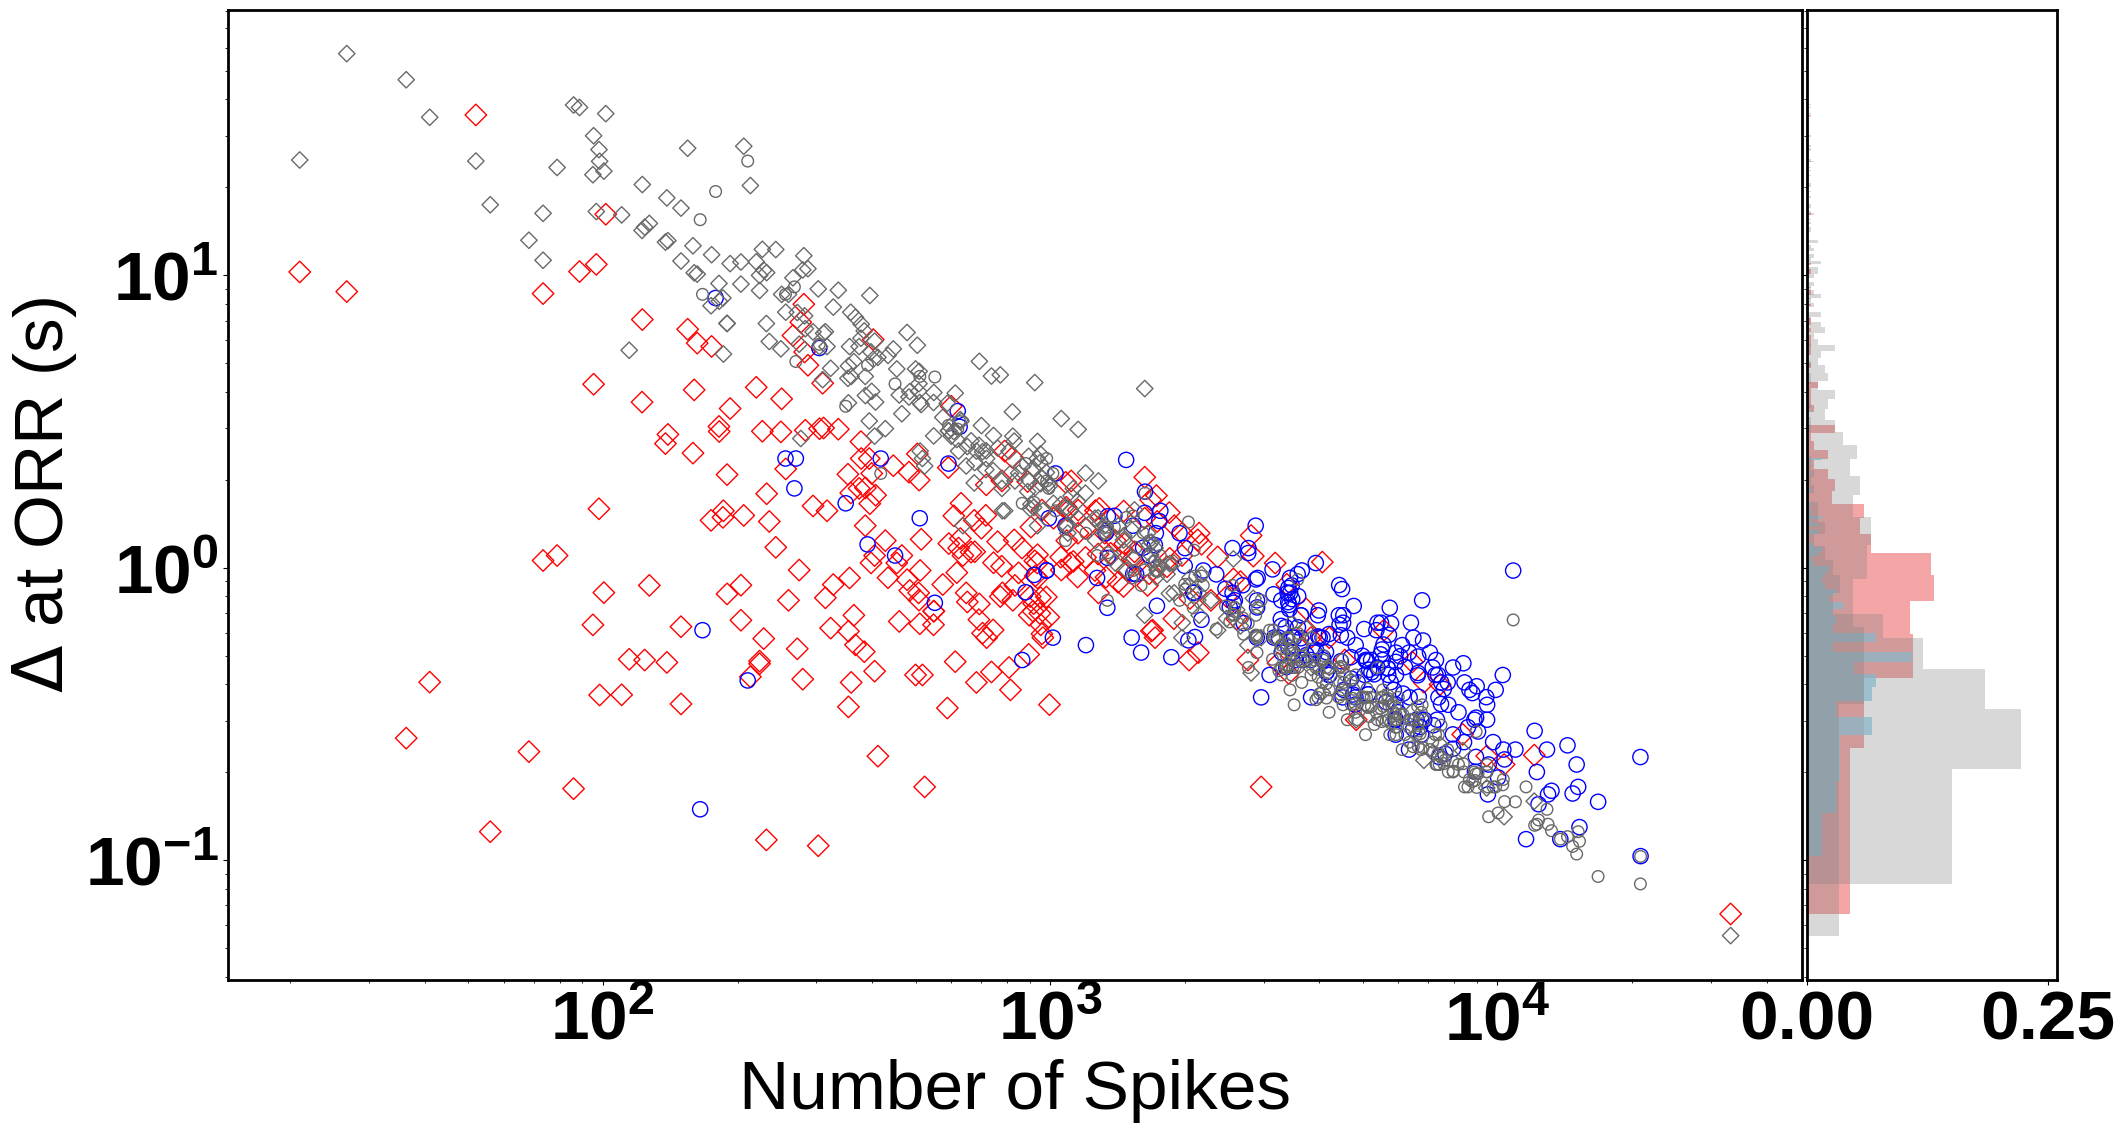

In [14]:
# Create scatter plot
fig, ax = plt.subplots()
quant='dt_OHK'
quant_lab=r'$\Delta$ at ORR (s)'
figname='../figures/DeltaORRvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

#msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,6],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
# ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 200
c1,b1=np.histogram(df.query('LOC=="CA1"')[quant], bins=bins)
ax_histy.hist(b1[:-1],b1,weights=c1/sum(c1), orientation='horizontal',color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
c2,b2=np.histogram(df.query('LOC=="SUB"')[quant], bins=bins)
ax_histy.hist(b2[:-1],b2,weights=c2/sum(c2), orientation='horizontal',color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')


# Plot histogram for 'poss_quant' data
c3,b3=np.histogram(df.query('LOC=="CA1"')['poss_'+quant], bins=bins)
ax_histy.hist(b3[:-1],b3,weights=c3/sum(c3), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
c4,b4=np.histogram(df.query('LOC=="SUB"')['poss_'+quant], bins=bins)
ax_histy.hist(b4[:-1],b4,weights=c4/sum(c4), orientation='horizontal',color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');ax.set_yscale('log');
# ax.set_ylim(0.1, 0.7)
ax_histy.set_xlim(0,0.26)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

In [15]:
import plotly.express as px


px.scatter(data_frame=df, x='Nspikes', y=['MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["RatID","task"],marginal_y='histogram',template='simple_white')

#px.scatter(data_frame=data, x='Nspikes', y=['MSR','poss_MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["task"],marginal_y='histogram')

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# px.scatter(data_frame=data, x='Nspikes', y=['MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["task"],marginal_y='histogram')